<a href="https://colab.research.google.com/github/kvn4/Smart-Contract-Auditing-AI-SCAAI-/blob/main/SCAAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

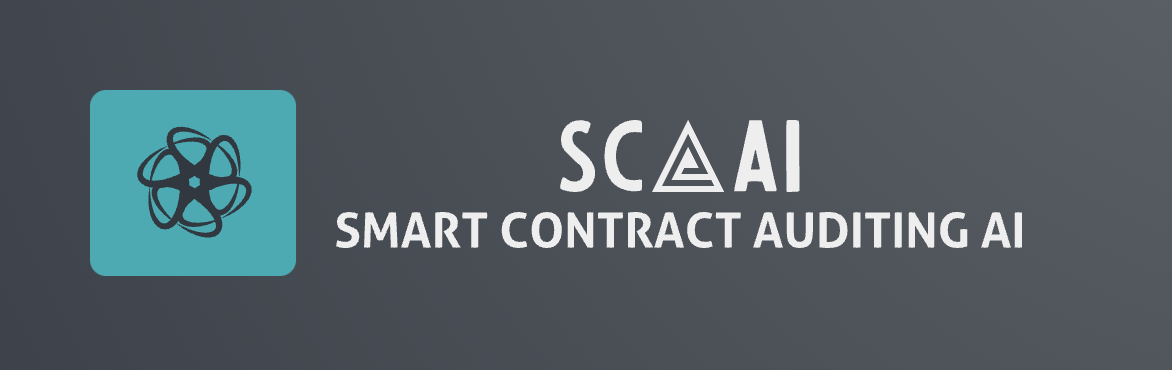





**`Install pretrained model and data`**

In [ ]:
! pip install git+https://github.com/huggingface/transformers.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-8dmpoqt1
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-8dmpoqt1
  Resolved https://github.com/huggingface/transformers.git to commit c836f77266be9ace47bff472f63caf71c0d11333
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 64.0 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.27.0.dev0-py3-none-any.whl size=6464552 sha256=ca585cdad3b60f5076d85650f6748df6e7b5f65869a0cc4f2ead186bd2fdece7
  Stored in directory: /tmp/pip-ephem-wheel-cache-pcmsgf7g/wheels/05/0a/97/64ae47c27ba95fae2cb5838e7b4b724

**`Import Data Files`**

In [ ]:
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**`Modify Dataset Path Location`**

In [ ]:
dataset_path = "[DATA SET PATH]"

**`Converts Input Dataset to String Array`**

In [ ]:
from numpy import array
from glob import glob
from pathlib import Path
import itertools
import numpy as np
import random
import pandas as pd
import json

def generate_dataset(dataset_path:str, samples_per_script:int) -> array:

    # array of tupels, (input_string, label) 
    dataset = []
    
    safe_scripts = glob(f'{dataset_path}/scripts/safe/*.txt')
    vun_scripts = glob(f'{dataset_path}/scripts/vun/*.txt')
    name_files = glob(f'{dataset_path}/names/*.txt')

    # load data from files
    names = {}
    for file in name_files:
        name = Path(file).stem
        samples = [n.lower()for n in open(file).read().splitlines() if not n.startswith('#')]
        names[name] = samples

    scripts = []
    for file in safe_scripts:
        sample = open(file).read().lower()
        scripts.append((sample, 0))

    for file in vun_scripts:
        sample = open(file).read().lower()
        scripts.append((sample, 1))

    filled_scripts = []
    filled_scripts_labels = []
    for script in scripts:

        script_text_raw = script[0]
        script_label = script[1]
        
        # pre-process the script
        script_text_raw = script_text_raw.replace('\n', ' new_line ')
        script_text_raw = " ".join(script_text_raw.split())
        script_text = []

        # replace all entities with their permitations
        for word in script_text_raw.split():
            if word.startswith('{') and word.endswith('}'):
                # the word is a entity, swap it out for the permutations
                entity = word[1:-1]
                
                script_text.append(names[entity])
            else:
                script_text.append([word])

        filled_scripts.append(script_text)
        filled_scripts_labels.append(script_label)

    # generate all permitations
    print('Loading permutations')
    permutations = []
    permutation_labels = []
    for i in range(samples_per_script):
        for sample, label in zip(filled_scripts, filled_scripts_labels):
            
            per = ""
            for s in sample:
                per += s[random.randint(0, len(s)-1)]
                per += " "

            permutations.append(per)
            permutation_labels.append(label)

    # generate the dataset
    Xs = np.array([p for p in permutations])
    ys = np.array(permutation_labels)

    dataset = []
    for x, y in zip(Xs, ys):
        dataset.append({
            'label': f"{y}",
            'contract': x
        })
    return dataset

    df = pd.DataFrame(dataset)
    df.to_pickle(f'{dataset_path}/train.pkl')

    with open(f'{dataset_path}/sample.json', 'w') as f:
        json.dump(dataset[::20], f)

dataset = generate_dataset("/content/drive/MyDrive/dataset", 20)

Loading permutations


**`Single Contract Inputs`**

In [ ]:
data = "[ENTER CONTRACT]"
dataset = [{"contract" : data}]

**`Truncates Data`**

In [ ]:
for i in range(len(dataset)):
  if(len(dataset[i]["contract"]) > 512 ):
    dataset[i]["contract"] = dataset[i]["contract"][:512]

**`Import Pretrained Model and Runs Model on Training Data`**

In [ ]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")

for i in range(len(dataset)):
  result = classifier(dataset[i]["contract"])[0]
  print(f"\nlabel: {result['label']}, with score: {round(result['score'], 4)}")

**`Evaluation on Single Contract Data`**

In [ ]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")

for i in range(len(dataset)):
  result = classifier(dataset)[0]
  print(f"label: {result['label']}, with score: {round(result['score'], 4)}")